In [38]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import cv2 
from tqdm import tqdm

# Mini-project 1: Dealing with sparse rewards in the Mountain Car environment

# 1 Introduction

### 1.1 Mountain Car Environment

In [39]:
env = gym.make('MountainCar-v0', render_mode="rgb_array")

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

starting_state, _ = env.reset() 
print(f"Starting state: {starting_state}")

done = False
state, _ = env.reset()
episode_reward = 0
while not done:
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)

    episode_reward += reward

    state = next_state
    done = terminated or truncated

print(f"Episode reward after taking random actions: {episode_reward}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Number of actions available: 3
Observation shape: (2,)
Starting state: [-0.59245926  0.        ]
Episode reward after taking random actions: -200.0


### 1.2 Agents

In [40]:
class Agents():
    def __init__(self, env):
        self.done = False
        self.env = env

    def observe(self, action, next_state, reward):
        None 
    
    def select_action(self, state):
        None

    def update(self):
        None

# 2. First steps

In [41]:
class RandomAgent(Agents):
    def __init__(self, env):
        super().__init__(env)
    
    def select_action(self, state):
        return self.env.action_space.sample()

In [42]:
def episode(env, agent):
    state, _ = env.reset()
    done = False

    episode_reward = 0
    episode_length = 0
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        episode_reward += reward
        episode_length += 1

        state = next_state
        done = terminated or truncated

    return episode_reward, episode_length

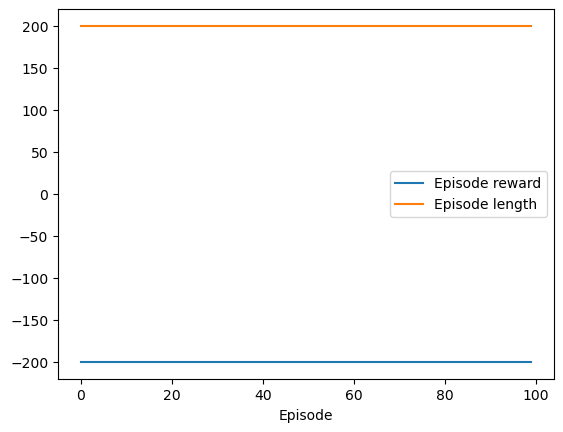

In [43]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = RandomAgent(environment)

num_episodes = 100
episode_rewards = np.empty(num_episodes)
episode_lengths = np.empty(num_episodes)
for i in range(num_episodes):
    episode_rewards[i], episode_lengths[i] = episode(environment, agent)

plt.figure()
plt.plot(episode_rewards, label="Episode reward")
plt.plot(episode_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.show()

Episode rewaard and episode lentgh are always -200 and 200, which is the default value for truncated=True. 

Basically, random sample of actions never solves the problem. 

# 3. DQN

### 3.1 Implementation 

In [44]:
class Q(torch.nn.Module): 
    def __init__(self):
        super(Q, self).__init__()
        
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            #torch.nn.Linear(64, 64),
            #torch.nn.ReLU(),
            torch.nn.Linear(64, 3))

    def forward(self, state):
        Q_values = self.MLP(state)
        return Q_values

## 3.4 Non domain-specific reward
class MLP(torch.nn.Module): 
    def __init__(self):
        super(MLP, self).__init__()
        
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1))

    def forward(self, state):
        output = self.MLP(state)
        return output

In [45]:
class ReplayBuffer:    
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.num_samples = 0
        self.buffer = torch.zeros((self.capacity, 7))
        
    def add_observation(self, observation):
        #observation = (state, action, reward, next_state, done)
        index = self.num_samples % self.capacity

        self.buffer[index] = observation
        self.num_samples += 1

    def sample_batch(self,batch_size=64):
        record_range = min(self.num_samples, self.capacity)
        indices = torch.randint(0,record_range,size=(batch_size,))
        return self.buffer[indices]
    
    def __len__(self):
        return min(self.num_samples, self.capacity)

In [110]:
class DQNAgent(Agents):
    def __init__(self,env, epsilon = 0.9, batch_size=64):
        super().__init__(env)
        self.Q = Q()
        self.discount_factor = 0.99
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.optimizer = torch.optim.AdamW(self.Q.parameters(), lr=1e-3)
        self.replay_buffer = ReplayBuffer()

        ## 3.4 Non domain-specific reward
        self.target_network = MLP()
        self.target_network.requires_grad_(False)
        self.predictor_network = MLP()
        self.predictor_optimizer = torch.optim.AdamW(self.predictor_network.parameters(), lr=1e-3)

    def observe(self, state, action, reward, next_state, done):
        self.replay_buffer.add_observation(torch.tensor([state[0], state[1], action, reward, next_state[0], next_state[1], done], dtype=torch.float32))

    def update_epsilon(self):
        self.epsilon *= 0.99
        self.epsilon = max(self.epsilon, 0.05)
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.Q(torch.tensor(state, dtype=torch.float32)).numpy()
                max_indices = np.argwhere(q == q.max())
                return np.random.choice(max_indices[0])
    
    def update(self):
        #batch.shape = (B, (S_x, S_v, A, R, S'_x, S'_v))
        batch = self.replay_buffer.sample_batch(self.batch_size)
        self.optimizer.zero_grad()

        batch_next_state_Q_values = self.Q(batch[:, 4:6]).clone().detach() # shape = (B, 3) 3 is action space
        
        current_Q_value =  torch.gather(self.Q(batch[:, :2]), dim=1, index=batch[:, 2].long().unsqueeze(1)).squeeze(1)
        batch_next_state_max_Q_value = torch.max(batch_next_state_Q_values, dim=1).values
        target_Q_value = batch[:, 3] + self.discount_factor*batch_next_state_max_Q_value*(1-batch[:, 6]) # Only reward if state is done
        loss = torch.functional.F.mse_loss(current_Q_value, target_Q_value)
        
        #batch_max_next_state_Q_value = torch.max(batch_next_state_Q_values, dim=1).values
        #loss = 0.5 * torch.mean((batch[:, 3] + self.discount_factor*batch_max_next_state_Q_value 
        #              - self.Q(batch[:, :2])[:, batch[:, 2].int()])**2)
        
        loss.backward()
        self.optimizer.step()

        ## 3.4 Non domain-specific reward
        next_states = batch[:, 4:6]
        targets = self.target_network(next_states)
        predictions = self.predictor_network(next_states)
        loss_predictor = torch.functional.F.mse_loss(predictions, targets)
        loss_predictor.backward()
        self.predictor_optimizer.step()

        return loss.item()    
    
    ## 3.4 Non domain-specific reward
    def RND_reward(self, next_states):
        next_states = torch.tensor(next_states, dtype=torch.float32)
        next_states = (next_states - torch.mean(next_states, dim=0))/torch.std(next_states, dim=0)
        rnd_reward = torch.functional.F.mse_loss(self.target_network(next_states), self.predictor_network(next_states)).detach().numpy()
        #rnd_reward = (rnd_reward - torch.mean(rnd_reward))/np.std(rnd_reward) TO DO: running estimate of its mean
        rnd_reward = -5 if rnd_reward < -5 else rnd_reward
        rnd_reward = 5 if rnd_reward > 5 else rnd_reward
        return rnd_reward

### 3.2 No auxiliary reward

In [47]:
def run_episode_DQN(agent, render=False, video_path="video.mp4", truncation = 200):

    state, _ = environment.reset()
    done = False
    
    episode_reward = 0
    episode_length = 0
    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = environment.step(action)
        agent.observe(state, action, reward, next_state, terminated)

        #if terminated:
            #print("Goal Found:", episode_reward, episode_length)

        if (len(agent.replay_buffer) > agent.batch_size):
            agent.update()
            agent.update_epsilon()
        
        episode_reward += reward
        episode_length += 1
        state = next_state
        done = terminated or (episode_reward - 1 < -truncation)
        
    if render:
        out.release()
    return episode_reward, episode_length

In [48]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = DQNAgent(environment)

list_rewards, list_lengths = ([], [])
for episode in tqdm(range(1000)):
    if (episode==999): kwargs = dict(render=True, video_path="video_dqn_3.2_trunc200.mp4")
    else: kwargs = dict(render=False)

    episode_reward, episode_length = run_episode_DQN(agent=agent, **kwargs)
    list_rewards.append(episode_reward)
    list_lengths.append(episode_length)

100%|██████████| 1000/1000 [02:31<00:00,  6.61it/s]


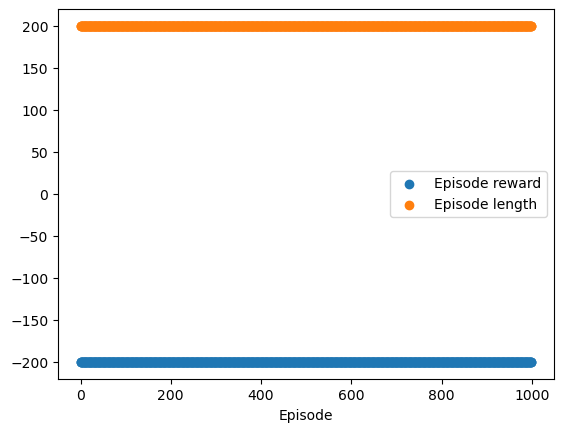

In [49]:
plt.figure()
plt.scatter(np.arange(len(list_rewards)),list_rewards, label="Episode reward")
plt.scatter(np.arange(len(list_lengths)),list_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.show()

In [50]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = DQNAgent(environment)

list_rewards, list_lengths = ([], [])
for episode in tqdm(range(1000)):
    if (episode==999): kwargs = dict(render=True, video_path="video_dqn_3.2_trunc1000.mp4")
    else: kwargs = dict(render=False)

    total_reward, duration = run_episode_DQN(agent=agent, truncation=1000, **kwargs)
    list_rewards.append(total_reward)
    list_lengths.append(duration)

100%|██████████| 1000/1000 [02:47<00:00,  5.95it/s]


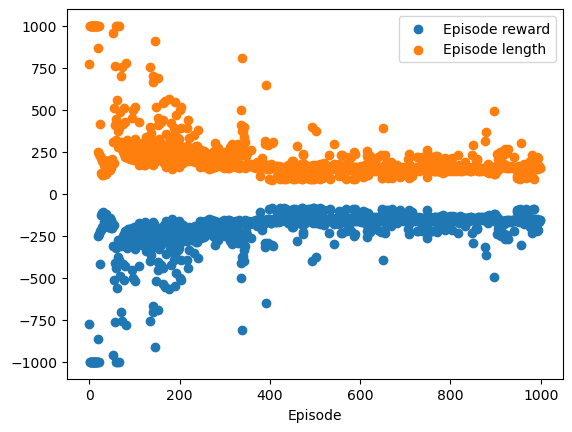

In [51]:
plt.figure()
plt.scatter(np.arange(len(list_rewards)),list_rewards, label="Episode reward")
plt.scatter(np.arange(len(list_lengths)),list_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.show()

Because of the sparse reward, the agend doesn't solve the task for episodes shorter than approximately 250 steps, tipycally not for the default duration 200 steps. If we allow longer steps, the agent is equivalent to random until it reaches once the goal, and after that it improves (his episode lenghts/episode rewards lowers/augments).

### 3.3 Heuristic reward function

In [59]:
def heuristic_reward_function(next_state):
    position, velocity = next_state

    # favour high speed to be able to climb the hill
    velocity_reward = velocity

    # favour positions close to the goal state 
    goal_position = 0.5
    position_reward = max(position, goal_position)

    # scale each reward 
    heuristic_reward = 0.5 * position_reward + 0.5 * velocity_reward

    return heuristic_reward

In [79]:
def run_episode_heuristic_DQN(agent, render=False, video_path="video.mp4", truncation = 200, reward_factor=3):

    state, _ = environment.reset()
    done = False
    
    episode_reward = 0
    episode_length = 0
    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = environment.step(action) 
        reward = reward + reward_factor * heuristic_reward_function(next_state) 

        agent.observe(state, action, reward, next_state, terminated)

        #if terminated:
            #print("Goal Found:", episode_reward, episode_length)

        if (len(agent.replay_buffer) > agent.batch_size):
            agent.update()
            agent.update_epsilon()
        
        episode_reward += reward
        episode_length += 1
        state = next_state
        done = terminated or episode_length > truncation
        
    if render:
        out.release()
    return episode_reward, episode_length

In [80]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = DQNAgent(environment)

list_rewards, list_lengths = ([], [])
for episode in tqdm(range(3000)):
    if (episode==2999): kwargs = dict(render=True, video_path="video_dqn_3.3_trunc200.mp4")
    else: kwargs = dict(render=False)

    total_reward, duration = run_episode_heuristic_DQN(agent=agent,truncation = 200, **kwargs)
    list_rewards.append(total_reward)
    list_lengths.append(duration)

100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


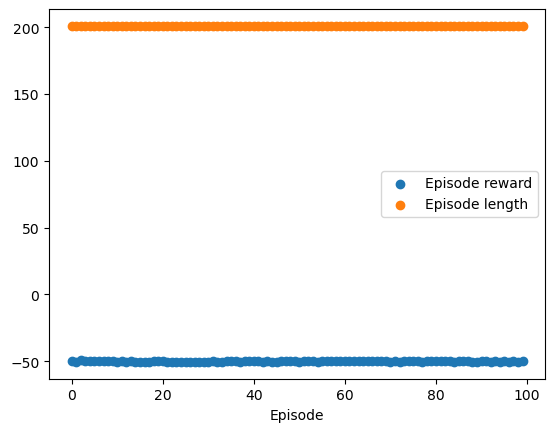

In [81]:
plt.figure()
plt.scatter(np.arange(len(list_rewards)),list_rewards, label="Episode reward")
plt.scatter(np.arange(len(list_lengths)),list_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.show()

MAKE ALL THE FINAL PLOTS

### 3.4 Non domain-specific reward

Why ar ethe normalization necessary ? 

In [111]:
def run_episode_RND_DQN(agent, render=False, video_path="video.mp4", truncation = 200, reward_factor=3):

    state, _ = environment.reset()
    done = False
    
    episode_reward = 0
    episode_length = 0
    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = environment.step(action) 
        reward = reward + reward_factor * agent.RND_reward(next_state)

        agent.observe(state, action, reward, next_state, terminated)

        #if terminated:
            #print("Goal Found:", episode_reward, episode_length)

        if (len(agent.replay_buffer) > agent.batch_size):
            agent.update()
            agent.update_epsilon()
        
        episode_reward += reward
        episode_length += 1
        state = next_state
        done = terminated or episode_length > truncation
        
    if render:
        out.release()
    return episode_reward, episode_length

what range of values for reward_factor make sense ? 

In [112]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = DQNAgent(environment)

list_rewards, list_lengths = ([], [])
for episode in tqdm(range(3000)):
    if (episode==2999): kwargs = dict(render=True, video_path="video_dqn_3.4_trunc200.mp4")
    else: kwargs = dict(render=False)

    total_reward, duration = run_episode_RND_DQN(agent=agent,truncation = 200, **kwargs)
    list_rewards.append(total_reward)
    list_lengths.append(duration)

100%|██████████| 3000/3000 [08:21<00:00,  5.99it/s]


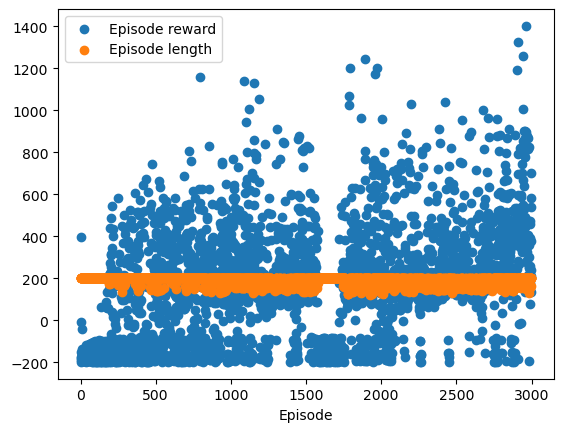

In [113]:
plt.figure()
plt.scatter(np.arange(len(list_rewards)),list_rewards, label="Episode reward")
plt.scatter(np.arange(len(list_lengths)),list_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.show()

MAKE ALL THE FINAL PLOTS

# 4. Dyna